<a href="https://colab.research.google.com/github/tathagat2000/practice/blob/master/ASHRAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf 
tf.test.gpu_device_name() 

'/device:GPU:0'

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as PLT
from matplotlib import image as mpimg
import scipy
from scipy import misc
import imageio
import os
import keras
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
from google.colab import drive 
drive.mount('/mntDrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /mntDrive


In [0]:
path = "/mntDrive/My Drive/Kaggle_Ashrae_Data/building_metadata.csv"
test=pd.read_csv("/mntDrive/My Drive/Kaggle_Ashrae_Data/test.csv")
#train=pd.read_csv("/mntDrive/My Drive/Kaggle_Ashrae_Data/train.csv")
building=pd.read_csv("/mntDrive/My Drive/Kaggle_Ashrae_Data/building_metadata.csv")
weather_test=pd.read_csv("/mntDrive/My Drive/Kaggle_Ashrae_Data/weather_test.csv")
#weather_train=pd.read_csv("/mntDrive/My Drive/Kaggle_Ashrae_Data/weather_train.csv")



In [0]:
weather_train=pd.read_csv("/mntDrive/My Drive/Kaggle_Ashrae_Data/weather_train.csv")

In [0]:

weather_test.fillna(0)
building.fillna(0)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,0.0
1,0,1,Education,2720,2004.0,0.0
2,0,2,Education,5376,1991.0,0.0
3,0,3,Education,23685,2002.0,0.0
4,0,4,Education,116607,1975.0,0.0
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,0.0
1445,15,1445,Education,4298,0.0,0.0
1446,15,1446,Entertainment/public assembly,11265,1997.0,0.0
1447,15,1447,Lodging/residential,29775,2001.0,0.0


In [0]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [0]:
test , NAlist = reduce_mem_usage(test)
weather_test , NAlist = reduce_mem_usage(weather_test)
building , NAlist = reduce_mem_usage(building)




Memory usage of properties dataframe is : 1272.5098876953125  MB
******************************
Column:  row_id
dtype before:  int64
min for this col:  0
max for this col:  41697599
dtype after:  uint32
******************************
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  596.4890747070312  MB
This is  46.87500509621608 % of the initial size
Memory usage of properties dataframe is : 19.036888122558594  MB
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  air_temperature
dtype before:  float64
min

In [0]:
test

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00
...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00
41697596,41697596,1445,0,2018-05-09 07:00:00
41697597,41697597,1446,0,2018-05-09 07:00:00
41697598,41697598,1447,0,2018-05-09 07:00:00


In [0]:
test = test.merge(building, how='left' , on='building_id' )
test = test.merge(weather_test , how='left' , left_on=['site_id' , 'timestamp'], right_on=['site_id' , 'timestamp'])


In [0]:
test.fillna(0)

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008,0,17.799999,4.0,11.7,-2.0,1021.400024,100.0,3.6
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004,0,17.799999,4.0,11.7,-2.0,1021.400024,100.0,3.6
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991,0,17.799999,4.0,11.7,-2.0,1021.400024,100.0,3.6
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002,0,17.799999,4.0,11.7,-2.0,1021.400024,100.0,3.6
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975,0,17.799999,4.0,11.7,-2.0,1021.400024,100.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00,15,Entertainment/public assembly,19619,1914,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
41697596,41697596,1445,0,2018-05-09 07:00:00,15,Education,4298,1899,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
41697597,41697597,1446,0,2018-05-09 07:00:00,15,Entertainment/public assembly,11265,1997,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
41697598,41697598,1447,0,2018-05-09 07:00:00,15,Lodging/residential,29775,2001,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [0]:
test = test.drop(test.columns[[0,1,4]] , axis=1)

In [0]:
test = test.fillna(0)

In [0]:
onehot = pd.get_dummies(test.meter)
test = pd.concat([test, onehot], axis=1)

In [0]:
onehot = pd.get_dummies(test.primary_use)
test = pd.concat([test, onehot], axis=1)

In [0]:
test.count()

meter                            41697600
timestamp                        41697600
primary_use                      41697600
square_feet                      41697600
year_built                       41697600
floor_count                      41697600
air_temperature                  41697600
cloud_coverage                   41697600
dew_temperature                  41697600
precip_depth_1_hr                41697600
sea_level_pressure               41697600
wind_direction                   41697600
wind_speed                       41697600
0                                41697600
1                                41697600
2                                41697600
3                                41697600
Education                        41697600
Entertainment/public assembly    41697600
Food sales and service           41697600
Healthcare                       41697600
Lodging/residential              41697600
Manufacturing/industrial         41697600
Office                           4

In [0]:
test = test.drop(test.columns[[0,2]] , axis=1)

In [0]:
timestamp=test.iloc[:,0]

In [0]:
test = test.drop(test.columns[[0]] , axis=1)

In [0]:
timestamp = pd.to_datetime(timestamp)
test = pd.concat([test ,  (timestamp.dt.weekday)] , axis=1)
test = pd.concat([test ,(timestamp.dt.hour)] , axis=1 )

220

In [0]:
onehot=pd.get_dummies(test.iloc[:,30])
onehot1 = pd.get_dummies(test.iloc[:,31])
test = test.drop(test.columns[[30,31]] , axis=1)
test = pd.concat([test,onehot] , axis=1)
test = pd.concat([test , onehot1] , axis=1)


In [0]:
import gc
del onehot
del onehot1
del timestamp
del building
del weather_test

gc.collect()

30

In [0]:
from keras import Sequential
from keras.layers import Dense

def build_regressor():
    regressor = Sequential()
    regressor.add(Dense(units=1, input_dim=61))
    #regressor.add(Dense(units=15))
    #regressor.add(Dense(units=1))
    regressor.compile(optimizer= 'adam' , loss='mean_squared_logarithmic_error',  metrics=['mean_squared_error'])
    return regressor


In [0]:
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
from keras.losses import mean_squared_error as mse_loss
from keras.models import load_model

from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Instantiate the model as you please (we are not going to use this)
model2 = KerasRegressor(build_fn=build_regressor, epochs=10, batch_size=1024)

# This is where you load the actual saved model into new variable.
model2.model = load_model("/mntDrive/My Drive/Kaggle_Ashrae_Data/nn_classifier_linear.h5")

# Now you can use this to predict on new data (without fitting model2, because it uses the older saved model)












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
result = model2.predict(test[:1000])

In [0]:
Y_pred = []
i, chunksize = 0, 1000000
for idx in range(0, len(test), chunksize):
    Y_pred += list(model2.predict(test[idx:(i+1)*chunksize],
                verbose=1, batch_size=10000))
    i += 1
Y_pred = np.array(Y_pred)

697600/697600 [==============================] - 0s 1us/step


In [0]:
results = pd.DataFrame(Y_pred)

In [0]:
results.max()

0    725.206848
dtype: float32

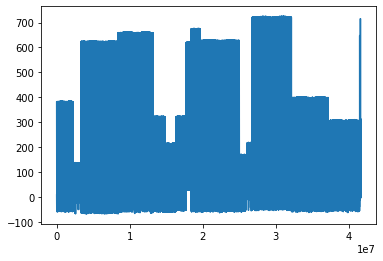

In [0]:
import matplotlib.pyplot as plt

plt.plot(results)

In [0]:
sum=0
for i in range(len(Y_pred)) :
  if Y_pred[i]<0 :
    sum=sum+1


print(sum)

0


In [0]:
results[results<0] = 50

In [0]:
results

,0
0,8.195786
1,4.610818
2,6.621751
3,20.548624
4,91.177223
...,...
41697595,13.413678
41697596,1.133769
41697597,7.115667
41697598,17.903793


In [0]:
sample_submission=pd.read_csv("/mntDrive/My Drive/Kaggle_Ashrae_Data/sample_submission.csv")

In [0]:
sample_submission.meter_reading = results

In [0]:
sample_submission

,row_id,meter_reading
0,0,8.195786
1,1,4.610818
2,2,6.621751
3,3,20.548624
4,4,91.177223
...,...,...
41697595,41697595,13.413678
41697596,41697596,1.133769
41697597,41697597,7.115667
41697598,41697598,17.903793


In [0]:
sample_submission.to_csv('sample_submission.csv' , index=False)

In [0]:
answer=sample_submission

In [0]:
sample_submission.to_csv(r"/mntDrive/My Drive/Kaggle_Ashrae_Data/answer02.csv"  , index=False)

In [0]:
!cp answer.csv  //mntDrive//My Drive

cp: target 'Drive' is not a directory


In [0]:
cp  --help

Usage: cp [OPTION]... [-T] SOURCE DEST
  or:  cp [OPTION]... SOURCE... DIRECTORY
  or:  cp [OPTION]... -t DIRECTORY SOURCE...
Copy SOURCE to DEST, or multiple SOURCE(s) to DIRECTORY.

Mandatory arguments to long options are mandatory for short options too.
  -a, --archive                same as -dR --preserve=all
      --attributes-only        don't copy the file data, just the attributes
      --backup[=CONTROL]       make a backup of each existing destination file
  -b                           like --backup but does not accept an argument
      --copy-contents          copy contents of special files when recursive
  -d                           same as --no-dereference --preserve=links
  -f, --force                  if an existing destination file cannot be
                                 opened, remove it and try again (this option
                                 is ignored when the -n option is also used)
  -i, --interactive            prompt before overwrite (overrides a previo

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
answer.to_pickle("/mntDrive/My Drive/Kaggle_Ashrae_Data/answer.csv")

OSError: ignored

In [0]:
sample_submission


,row_id,meter_reading
0,0,8.195786
1,1,4.610818
2,2,6.621751
3,3,20.548624
4,4,91.177223
...,...,...
41697595,41697595,13.413678
41697596,41697596,1.133769
41697597,41697597,7.115667
41697598,41697598,17.903793
